# Basic Usage of Dynamic HMC in IMP

## Introduction

Like most implementations of dynamic/adaptive Hamiltonian Monte Carlo (HMC),
IMP's is designed to be run for a warm-up period in which the step size and
metric are adapted in an automated fashion, followed by a sampling period.
Consequently, for most applications, the user will only need one function:
`IMP.hmc.defaults.setup_warmup_run_hmc`. For all of the options, consult the
source code. This notebook demonstrates how one would apply the HMC sampler on
several trivial sampling problems, analyze the output with
[ArviZ](https://arviz-devs.github.io/arviz), and compare with the usual Random
Walk Monte Carlo (RWMC) approach with Gibbs samplers typically used in IMP.

## Set-up and Imports

In [1]:
import numpy as np

import IMP
import IMP.core
import IMP.isd
import IMP.hmc
from IMP.hmc.defaults import setup_warmup_run_hmc
from IMP.hmc.diagnostics import get_inference_data
from IMP.hmc.julia import set_julia_seed

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import arviz as az  # arviz *must* be imported after IMP.hmc (for now)

az.style.use(["default", "arviz-colors"])

# Set random seeds
IMP.random_number_generator.seed(1608637542)
set_julia_seed(3421126067)
np.random.seed(4083286876)

In [2]:
def setup_nvariate_normal(
    m, N=1, mu=0.0, sigma=1.0, lb=-np.inf, ub=np.inf, make_movers=False
):
    rs = []
    ps = []

    try:
        list(mu)
    except TypeError:
        mu = [mu] * N

    try:
        list(sigma)
    except TypeError:
        sigma = [sigma] * N

    movers = []

    for n in range(N):
        p = IMP.isd.Nuisance.setup_particle(IMP.Particle(m))
        p.set_nuisance_is_optimized(True)
        
        if not np.isinf(lb):
            p.set_lower(lb)
        if not np.isinf(ub):
            p.set_upper(ub)
        p.set_name("x{}".format(n))
        ps.append(p)

        r = IMP.isd.GaussianRestraint(p.get_particle(), mu[n], sigma[n])
        rs.append(r)

        if make_movers:
            mvr = IMP.core.NormalMover(
                m, p.get_particle_index(), [p.get_nuisance_key()], 1.0
            )
            movers.append(mvr)

    rs = IMP.RestraintSet(rs, 1.0)
    sf = IMP.core.RestraintsScoringFunction(rs)

    if make_movers:
        return ps, sf, movers

    return ps, sf


ess_cols = ["ess_mean", "ess_sd", "ess_bulk", "ess_tail"]

## $N$-variate Normal

### 1D normal

#### HMC

In [3]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=1, make_movers=True)
for p in ps:
    p.set_nuisance(np.random.normal())
hmc = setup_warmup_run_hmc(sf, metric="unit", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("tree_size").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 5.65s (0.00225s/eval)
9 divergent transitions were encountered during warm-up (0.900%%)
Mean warm-up statistics:
    step_size: 1.39
    tree_size: 2.51
    is_accept: 1
    mean_tree_accept: 0.791
    lp: -1.44
    energy: 1.94
    depth: 1.39
    diverging: 0.009
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    step_size: 0.637
    tree_size: 3.75
    is_accept: 1
    mean_tree_accept: 0.972
    lp: -1.42
    energy: 1.9
    depth: 1.79
    diverging: 0
7506 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,-0.015,1.004,-1.944,1.766,0.046,0.039,477.0,340.0,491.0,375.0,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5b77add0>],
      dtype=object)

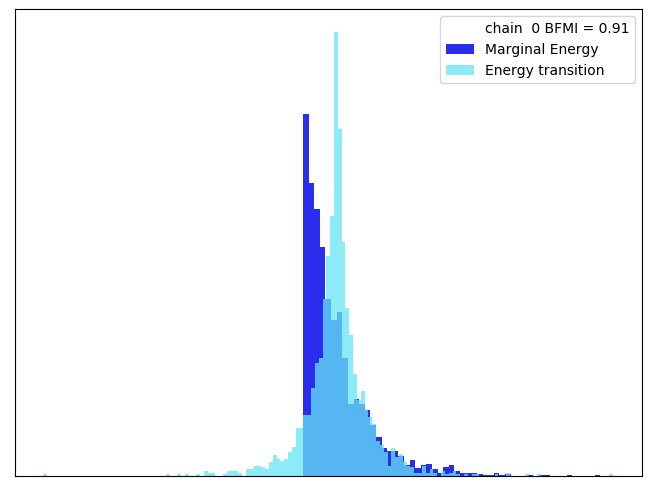

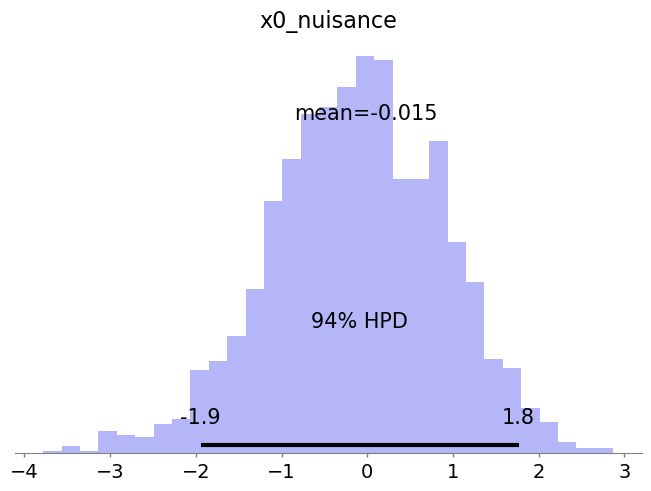

In [4]:
az.plot_energy(hmc_dataset, kind="hist")
az.plot_posterior(hmc_dataset, kind="hist")

#### RWMC

In [5]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(5)
for p in ps:
    p.set_nuisance(np.random.normal())

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1782), minimum_shape: (chains=2, draws=4)


Acceptance rate: 0.237


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.019,1.098,-1.942,2.051,0.028,0.022,1543.0,1211.0,1547.0,1434.0,NaN


In [6]:
ess_ratios = hmc_summary[ess_cols] / rwmc_summary[ess_cols]
ess_ratios.columns = [c + "_ratio" for c in ess_cols]
ess_ratios

,ess_mean_ratio,ess_sd_ratio,ess_bulk_ratio,ess_tail_ratio
x0_nuisance,0.309138,0.28076,0.317388,0.261506


### 10D Normal

#### HMC

In [7]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=10, make_movers=True)
for p in ps:
    p.set_nuisance(np.random.normal())
hmc = setup_warmup_run_hmc(sf, metric="diag", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("tree_size").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 8.28s (0.000648s/eval)
7 divergent transitions were encountered during warm-up (0.700%%)
Mean warm-up statistics:
    step_size: 0.862
    tree_size: 12.8
    is_accept: 1
    mean_tree_accept: 0.791
    lp: -14.2
    energy: 19.3
    depth: 2.75
    diverging: 0.007
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

Mean HMC statistics:
    step_size: 0.794
    tree_size: 41.9
    is_accept: 1
    mean_tree_accept: 0.843
    lp: -14.2
    energy: 19.2
    depth: 3.88
    diverging: 0
83740 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,-0.045,1.009,-1.939,1.833,0.025,0.025,1575.0,810.0,1589.0,1321.0,NaN
x1_nuisance,-0.009,0.992,-1.708,1.962,0.022,0.023,2071.0,914.0,2071.0,1268.0,NaN
x2_nuisance,-0.067,0.958,-2.042,1.591,0.023,0.022,1743.0,947.0,1753.0,1361.0,NaN
x3_nuisance,0.023,0.989,-1.850,1.898,0.022,0.022,2098.0,996.0,2098.0,1189.0,NaN
x4_nuisance,-0.039,1.028,-2.031,1.771,0.024,0.023,1870.0,1033.0,1916.0,1456.0,NaN
x5_nuisance,-0.010,1.055,-1.873,2.035,0.025,0.025,1791.0,923.0,1791.0,1343.0,NaN
x6_nuisance,-0.021,1.008,-2.048,1.772,0.025,0.023,1673.0,1002.0,1676.0,1401.0,NaN
x7_nuisance,-0.006,1.008,-2.067,1.724,0.022,0.023,2077.0,940.0,2083.0,1293.0,NaN
x8_nuisance,-0.002,0.958,-2.069,1.561,0.022,0.022,1901.0,983.0,1902.0,1355.0,NaN
x9_nuisance,0.020,0.968,-1.832,1.828,0.019,0.024,2487.0,785.0,2470.0,1171.0,NaN


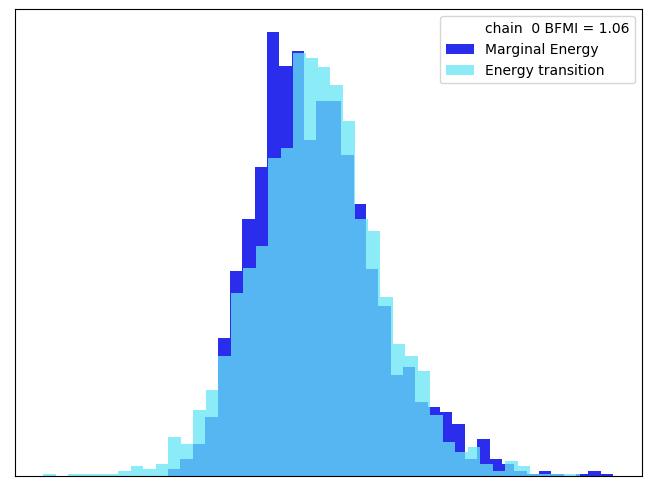

In [8]:
az.plot_energy(hmc_dataset, kind="hist")

#### RWMC

In [9]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(0.78)
for p in ps:
    p.set_nuisance(np.random.normal())

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2081), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2081), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2081), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2081), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2081), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2081), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2081), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2081), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

Acceptance rate: 0.248


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.050,1.061,-1.857,1.992,0.065,0.046,267.0,267.0,271.0,419.0,NaN
x1_nuisance,-0.005,1.046,-1.984,1.923,0.073,0.052,203.0,203.0,202.0,343.0,NaN
x2_nuisance,-0.033,1.037,-1.886,1.918,0.063,0.044,273.0,273.0,272.0,534.0,NaN
x3_nuisance,-0.053,1.058,-2.071,1.882,0.068,0.048,240.0,240.0,240.0,461.0,NaN
x4_nuisance,0.076,1.071,-1.912,2.075,0.066,0.047,264.0,264.0,265.0,528.0,NaN
x5_nuisance,-0.044,1.070,-2.033,1.897,0.073,0.051,217.0,217.0,217.0,443.0,NaN
x6_nuisance,-0.045,1.065,-2.030,1.936,0.069,0.049,237.0,237.0,239.0,398.0,NaN
x7_nuisance,0.073,1.030,-1.789,2.017,0.059,0.042,304.0,304.0,309.0,399.0,NaN
x8_nuisance,0.045,0.999,-1.814,1.935,0.064,0.045,243.0,243.0,243.0,486.0,NaN
x9_nuisance,-0.001,1.044,-1.883,1.970,0.058,0.041,323.0,323.0,322.0,481.0,NaN


In [10]:
ess_ratios = hmc_summary[ess_cols] / rwmc_summary[ess_cols]
ess_ratios.columns = [c + "_ratio" for c in ess_cols]
ess_ratios

,ess_mean_ratio,ess_sd_ratio,ess_bulk_ratio,ess_tail_ratio
x0_nuisance,5.898876,3.033708,5.863469,3.152745
x1_nuisance,10.201970,4.502463,10.252475,3.696793
x2_nuisance,6.384615,3.468864,6.444853,2.548689
x3_nuisance,8.741667,4.150000,8.741667,2.579176
x4_nuisance,7.083333,3.912879,7.230189,2.757576
x5_nuisance,8.253456,4.253456,8.253456,3.031603
x6_nuisance,7.059072,4.227848,7.012552,3.520101
x7_nuisance,6.832237,3.092105,6.741100,3.240602
x8_nuisance,7.823045,4.045267,7.827160,2.788066
x9_nuisance,7.699690,2.430341,7.670807,2.434511


### 100D Gaussian

#### HMC

In [11]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=100, make_movers=True)
for p in ps:
    p.set_nuisance(np.random.normal())
hmc = setup_warmup_run_hmc(sf, metric="diag", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("tree_size").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 21.8s (0.000666s/eval)
7 divergent transitions were encountered during warm-up (0.700%%)
Mean warm-up statistics:
    step_size: 0.558
    tree_size: 32.7
    is_accept: 1
    mean_tree_accept: 0.791
    lp: -142
    energy: 192
    depth: 3.64
    diverging: 0.007
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    step_size: 0.439
    tree_size: 9.97
    is_accept: 1
    mean_tree_accept: 0.862
    lp: -142
    energy: 192
    depth: 3.09
    diverging: 0
19936 scoring evaluations computed during sampling


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.019,1.009,-1.831,1.948,0.020,0.026,2657.0,773.0,2642.0,1286.0,NaN
x1_nuisance,-0.002,0.995,-1.929,1.773,0.020,0.023,2528.0,971.0,2534.0,1337.0,NaN
x2_nuisance,0.008,0.998,-1.799,1.955,0.019,0.023,2673.0,976.0,2657.0,1407.0,NaN
x3_nuisance,0.026,1.001,-1.960,1.843,0.022,0.023,2107.0,921.0,2117.0,1452.0,NaN
x4_nuisance,0.015,0.967,-1.660,2.088,0.020,0.023,2307.0,910.0,2321.0,1322.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
x95_nuisance,-0.018,0.988,-1.725,1.972,0.021,0.023,2138.0,929.0,2129.0,1371.0,NaN
x96_nuisance,0.045,0.968,-1.681,1.966,0.019,0.024,2520.0,841.0,2506.0,1553.0,NaN
x97_nuisance,-0.011,0.982,-1.922,1.780,0.021,0.025,2256.0,762.0,2282.0,1354.0,NaN
x98_nuisance,0.009,1.028,-1.963,1.886,0.021,0.024,2368.0,881.0,2369.0,1333.0,NaN


#### RWMC

In [12]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(0.23)
for p in ps:
    p.set_nuisance(np.random.normal())

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation fai

Acceptance rate: 0.231


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation fai

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 47), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation fai

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,-1.421,0.563,-2.099,-0.443,0.489,0.479,1.0,1.0,2.0,17.0,NaN
x1_nuisance,-0.199,0.580,-1.263,0.684,0.480,0.448,1.0,1.0,2.0,11.0,NaN
x2_nuisance,-0.291,0.304,-0.747,0.308,0.161,0.124,4.0,4.0,6.0,19.0,NaN
x3_nuisance,0.588,0.446,-0.036,1.434,0.276,0.223,3.0,3.0,3.0,15.0,NaN
x4_nuisance,0.063,0.895,-1.376,1.149,0.746,0.702,1.0,1.0,2.0,17.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
x95_nuisance,0.278,0.438,-0.624,1.064,0.132,0.150,11.0,5.0,11.0,17.0,NaN
x96_nuisance,0.453,1.137,-1.613,1.948,0.958,0.909,1.0,1.0,2.0,17.0,NaN
x97_nuisance,0.360,0.611,-0.624,1.385,0.492,0.450,2.0,2.0,2.0,12.0,NaN
x98_nuisance,0.713,0.440,0.012,1.403,0.291,0.240,2.0,2.0,2.0,11.0,NaN


In [13]:
ess_ratios = hmc_summary[ess_cols] / rwmc_summary[ess_cols]
ess_ratios.columns = [c + "_ratio" for c in ess_cols]
ess_ratios

,ess_mean_ratio,ess_sd_ratio,ess_bulk_ratio,ess_tail_ratio
x0_nuisance,2657.000000,773.0,1321.000000,75.647059
x1_nuisance,2528.000000,971.0,1267.000000,121.545455
x2_nuisance,668.250000,244.0,442.833333,74.052632
x3_nuisance,702.333333,307.0,705.666667,96.800000
x4_nuisance,2307.000000,910.0,1160.500000,77.764706
...,...,...,...,...
x95_nuisance,194.363636,185.8,193.545455,80.647059
x96_nuisance,2520.000000,841.0,1253.000000,91.352941
x97_nuisance,1128.000000,381.0,1141.000000,112.833333
x98_nuisance,1184.000000,440.5,1184.500000,121.181818


## Constrained variables

### $x \sim \operatorname{Half-Normal}(0, 1)$

#### HMC

In [14]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=1, lb=0, make_movers=True)
for p in ps:
    p.set_nuisance(np.exp(np.random.normal()))
hmc = setup_warmup_run_hmc(sf, metric="unit", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("tree_size").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 4.69s (0.00135s/eval)
40 divergent transitions were encountered during warm-up (4.000%%)
Mean warm-up statistics:
    step_size: 0.834
    tree_size: 3.48
    is_accept: 1
    mean_tree_accept: 0.792
    lp: -1.97
    energy: 2.5
    depth: 1.59
    diverging: 0.04
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    step_size: 1.92
    tree_size: 1.61
    is_accept: 1
    mean_tree_accept: 0.386
    lp: -2.08
    energy: 2.58
    depth: 0.962
    diverging: 0.238
3220 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.847,0.64,0.002,2.083,0.073,0.065,77.0,48.0,122.0,95.0,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5d3a3d90>],
      dtype=object)

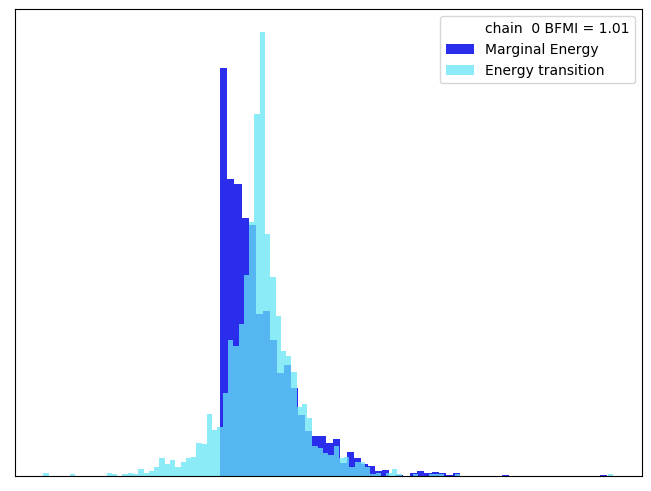

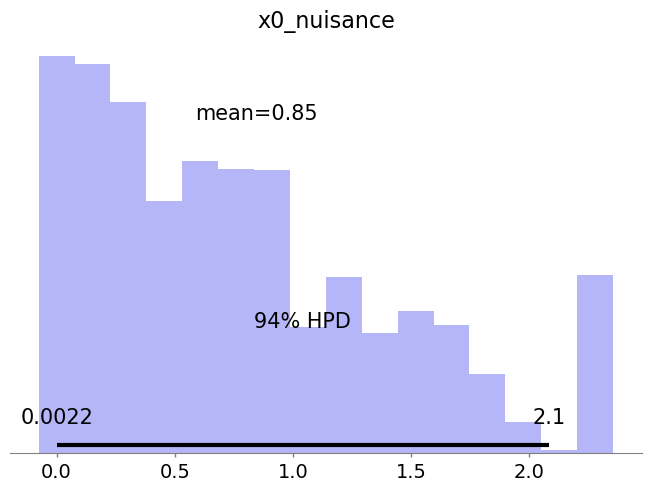

In [15]:
az.plot_energy(hmc_dataset, kind="hist")
az.plot_posterior(hmc_dataset, kind="hist")

#### RWMC

In [16]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(2)
for p in ps:
    p.set_nuisance(np.exp(np.random.normal()))

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2213), minimum_shape: (chains=2, draws=4)


Acceptance rate: 0.687


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.306,0.559,0.0,1.441,0.017,0.013,1046.0,873.0,1196.0,970.0,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5d259410>],
      dtype=object)

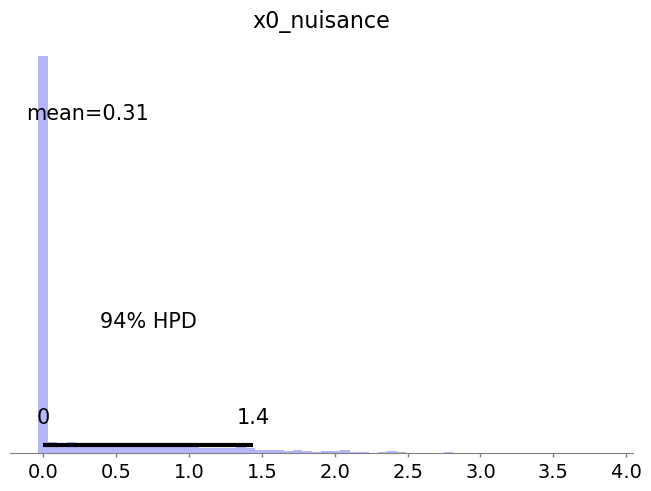

In [17]:
az.plot_posterior(rwmc_dataset, kind="hist")

In this example, we can see how IMP's constraint handling creates an invalid
Markov transition when the posterior is defined at the constraint value. Any
proposal that falls outside of the constraint is thresholded to the nearest
bound. If the scoring function is defined at that bound then the entirety of
the transition distributions mass outside the bound is placed at the bound,
and it will be accepted at a higher rate than it ought to be.

### $x \sim \operatorname{Truncated-Normal}(0, 1)$, $-1 < x < 1$

#### HMC

In [18]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=1, lb=-2, ub=2, make_movers=True)
for p in ps:
    p.set_nuisance(np.tanh(np.random.normal() / 2))
hmc = setup_warmup_run_hmc(sf, metric="diag", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("tree_size").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 4.48s (0.00164s/eval)
3 divergent transitions were encountered during warm-up (0.300%%)
Mean warm-up statistics:
    step_size: 1.28
    tree_size: 2.73
    is_accept: 1
    mean_tree_accept: 0.791
    lp: -1.58
    energy: 2.09
    depth: 1.5
    diverging: 0.003
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    step_size: 1.48
    tree_size: 1.82
    is_accept: 1
    mean_tree_accept: 0.623
    lp: -1.55
    energy: 2.03
    depth: 1.27
    diverging: 0
3632 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,-0.007,0.851,-1.489,1.656,0.03,0.021,821.0,821.0,767.0,813.0,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a601b1ad0>],
      dtype=object)

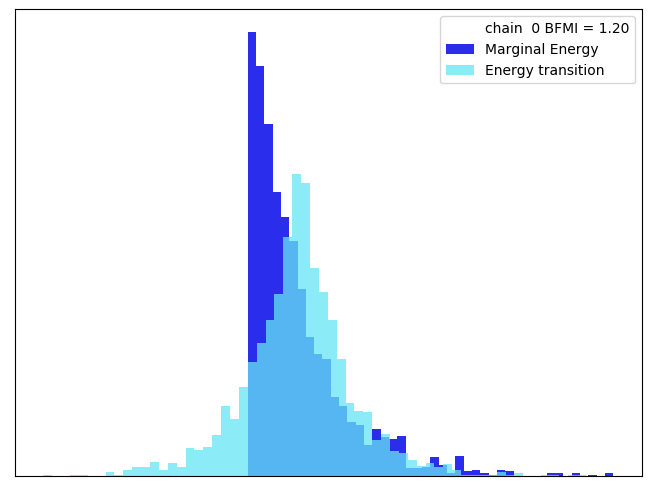

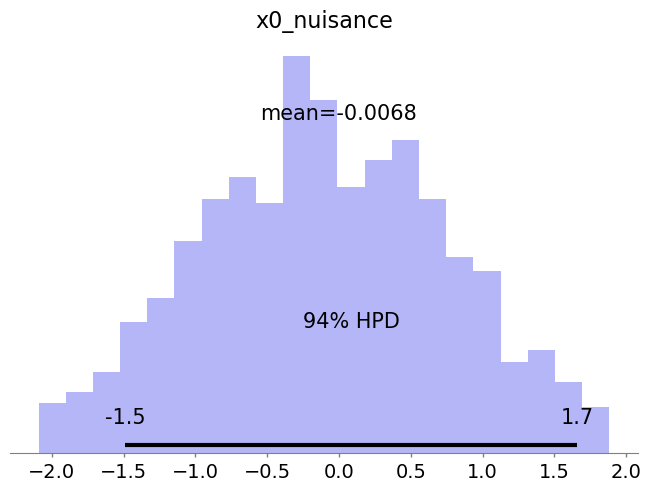

In [19]:
az.plot_energy(hmc_dataset, kind="hist")
az.plot_posterior(hmc_dataset, kind="hist")

#### RWMC

In [20]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(2)
for p in ps:
    p.set_nuisance(np.tanh(np.random.normal() / 2))

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2246), minimum_shape: (chains=2, draws=4)


Acceptance rate: 0.618


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,-0.06,1.267,-2.0,2.0,0.051,0.036,628.0,628.0,612.0,738.0,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a6031a8d0>],
      dtype=object)

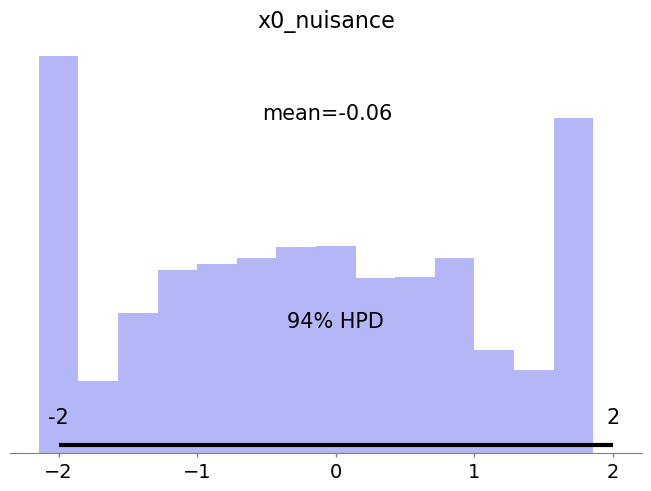

In [21]:
az.plot_posterior(rwmc_dataset, kind="hist")

### $x \sim \operatorname{vMF}(50)$, $x \in S^2$

Here $x$ is a 3D unit vector, an element of the 2-sphere, distributed
according to the von Mises-Fisher distribution with concentration of 50.

#### Restraint and Setup

In [22]:
class vonMisesFisherRestraint(IMP.Restraint):
    def __init__(self, x, mu, kappa):
        self.x = IMP.core.Direction(x)
        super().__init__(self.x.get_model(), "vonMisesFisherRestraint%1%")
        self.kappa = kappa
        self.mu = mu
        self.km = kappa * np.array(mu, dtype=np.double)

    def do_add_score_and_derivatives(self, sa):
        score = -self.km.dot(self.x.get_direction())
        if sa.get_derivative_accumulator():
            self.x.add_to_direction_derivatives(
                -self.km, sa.get_derivative_accumulator()
            )
        sa.add_score(score)

    def do_get_inputs(self):
        return [self.x.get_particle()]


def setup_S2_vMF(m, mu=np.array([0.0, 0.0, 1.0]), kappa=10.0, make_mover=False):
    rs = []

    p = IMP.core.Direction.setup_particle(
        IMP.Particle(m), IMP.algebra.get_random_vector_on_unit_sphere()
    )
    p.set_direction_is_optimized(True)
    p.set_name("x")

    r = vonMisesFisherRestraint(p, mu, kappa)
    rs.append(r)

    rs = IMP.RestraintSet(rs, 1.0)
    sf = IMP.core.RestraintsScoringFunction(rs)

    if make_mover:
        mvr = IMP.core.DirectionMover(p, 1.0, 0.0)
        return p, sf, mvr

    return p, sf

#### HMC

In [23]:
m = IMP.Model()
p, sf, mover = setup_S2_vMF(m, kappa=50, make_mover=True)
p.set_direction(IMP.algebra.get_random_vector_on_unit_sphere())

hmc = setup_warmup_run_hmc(
    sf, metric="diag", adapt_delta=0.9, nadapt=1000, nsample=2000
)
nsteps = hmc.stats.get_samples("tree_size").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc, varnames=["x", "y", "z"])
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 8.85s (0.000939s/eval)
7 divergent transitions were encountered during warm-up (0.700%%)
Mean warm-up statistics:
    step_size: 0.417
    tree_size: 9.42
    is_accept: 1
    mean_tree_accept: 0.89
    lp: 47.3
    energy: -45.8
    depth: 2.79
    diverging: 0.007
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    step_size: 0.681
    tree_size: 4.65
    is_accept: 1
    mean_tree_accept: 0.665
    lp: 47.5
    energy: -45.9
    depth: 2.05
    diverging: 0.0225
9294 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.002,0.137,-0.257,0.258,0.004,0.003,1296.0,940.0,1307.0,1224.0,NaN
y,-0.002,0.140,-0.264,0.258,0.004,0.004,1073.0,754.0,1074.0,1262.0,NaN
z,0.981,0.019,0.948,1.000,0.001,0.000,891.0,889.0,783.0,1050.0,NaN


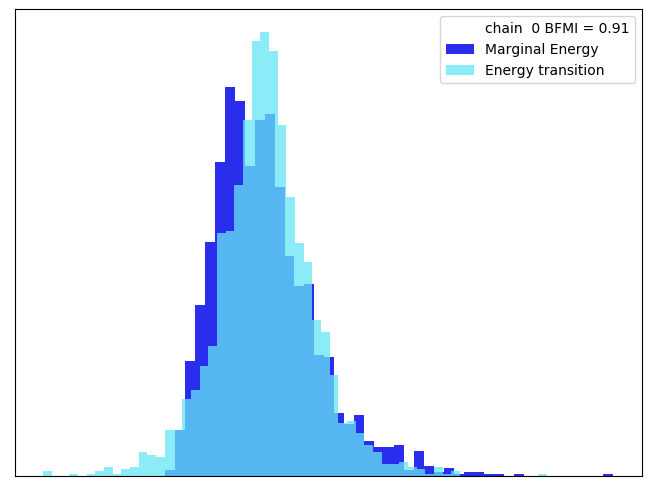

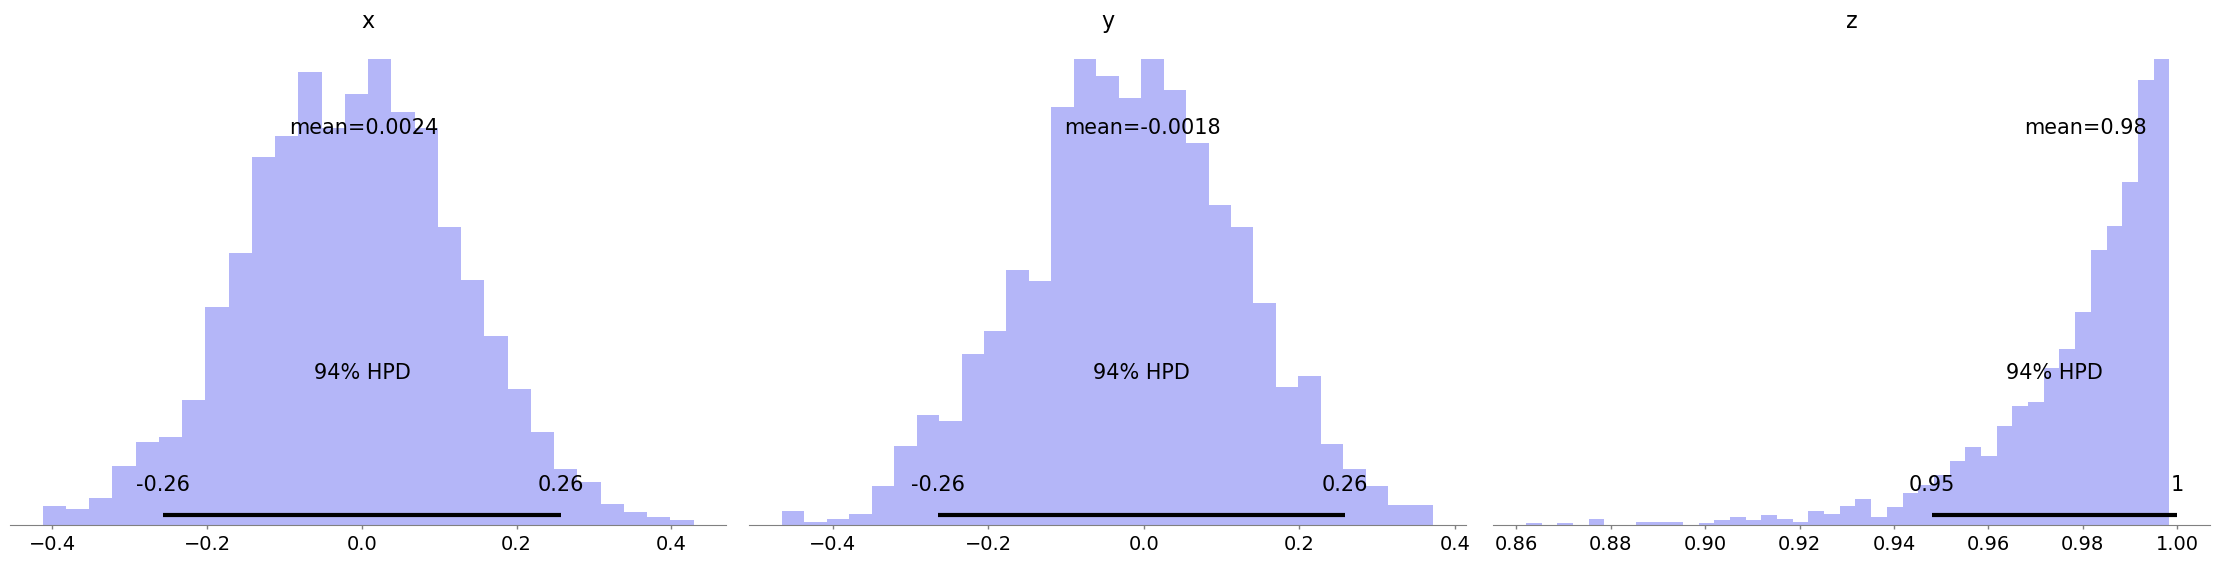

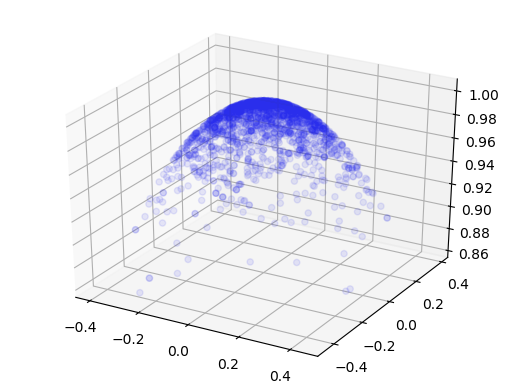

In [24]:
az.plot_energy(hmc_dataset, kind="hist")
az.plot_posterior(hmc_dataset, kind="hist")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    hmc_dataset.posterior.x, hmc_dataset.posterior.y, hmc_dataset.posterior.z, alpha=0.1
)
plt.show()

#### RWMC

In [25]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers([mover])
mover.set_maximum_rotation(0.9)
p.set_direction(IMP.algebra.get_random_vector_on_unit_sphere())

mc.optimize(nsteps)
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(nsteps)
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip("xyz", map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2387), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2387), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2387), minimum_shape: (chains=2, draws=4)


Acceptance rate: 0.257


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.001,0.152,-0.263,0.287,0.006,0.004,760.0,618.0,766.0,776.0,NaN
y,0.000,0.148,-0.260,0.281,0.005,0.004,986.0,878.0,991.0,1046.0,NaN
z,0.977,0.022,0.939,1.000,0.001,0.001,507.0,507.0,555.0,793.0,NaN


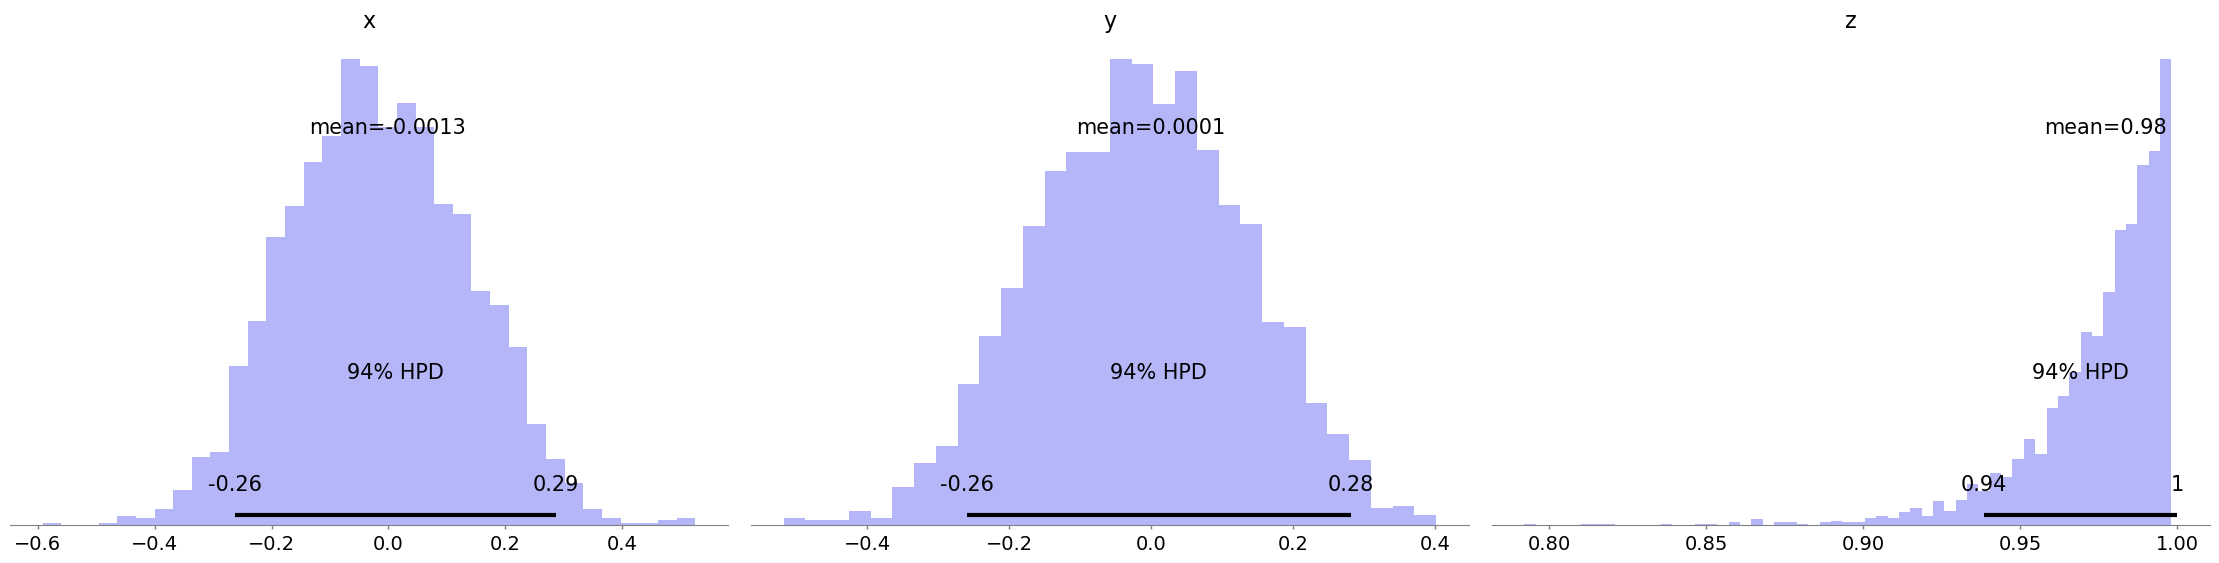

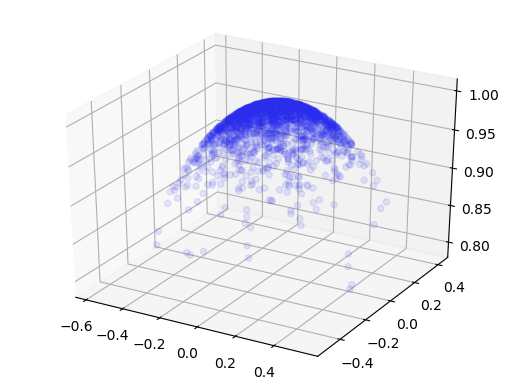

In [26]:
az.plot_posterior(rwmc_dataset, kind="hist")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    rwmc_dataset.posterior.x,
    rwmc_dataset.posterior.y,
    rwmc_dataset.posterior.z,
    alpha=0.1,
)
plt.show()

In [27]:
ess_ratios = hmc_summary[ess_cols] / rwmc_summary[ess_cols]
ess_ratios.columns = [c + "_ratio" for c in ess_cols]
ess_ratios

,ess_mean_ratio,ess_sd_ratio,ess_bulk_ratio,ess_tail_ratio
x,1.705263,1.521036,1.706266,1.577320
y,1.088235,0.858770,1.083754,1.206501
z,1.757396,1.753452,1.410811,1.324086


### $x \sim \operatorname{Dir}(\alpha)$, $x \in \Delta^2$, $\alpha=(4,8,16)^\top$

Here $x$ is a 3D point on the 2-simplex $\Delta^2$, the manifold of vectors with
positive elements that sum to 1. IMP's `IMP.isd.Weight` decorator represents
such simplices. Elements of $\Delta^2$ lie on an equiliteral triangular subset
of a plane. See https://en.wikipedia.org/wiki/Simplex for more details. Here, we
choose a Dirichlet prior with concentrations $\alpha=(4,8,16)^\top$. For
reference, $\alpha=(1,1,1)^\top$ is the uniform distribution on $\Delta^2$.

#### Restraint and Setup

In [28]:
class DirichletRestraint(IMP.Restraint):
    def __init__(self, x, alpha):
        self.x = IMP.isd.Weight(x)
        super().__init__(self.x.get_model(), "DirichletRestraint%1%")
        self.alpha = np.array(alpha, dtype=np.double)
        self.beta = self.alpha - 1

    def do_add_score_and_derivatives(self, sa):
        w = np.array(self.x.get_weights(), dtype=np.double)
        score = -np.dot(self.beta, np.log(w))
        if sa.get_derivative_accumulator():
            self.x.add_to_weights_derivatives(
                -self.beta / w, sa.get_derivative_accumulator()
            )
        sa.add_score(score)

    def do_get_inputs(self):
        return [self.x.get_particle()]


def get_random_weights(n):
    w = -np.log(np.random.uniform(size=n))
    return w / np.sum(w)


def setup_weight_dirichlet(m, alpha=np.ones(3), make_mover=False):
    rs = []

    n = len(alpha)
    w0 = get_random_weights(n)

    p = IMP.isd.Weight.setup_particle(IMP.Particle(m), w0)
    p.set_weights_are_optimized(True)
    p.set_name("x")

    r = DirichletRestraint(p, alpha)
    rs.append(r)

    rs = IMP.RestraintSet(rs, 1.0)
    sf = IMP.core.RestraintsScoringFunction(rs)

    if make_mover:
        mvr = IMP.isd.WeightMover(p.get_particle(), 1.0)
        return p, sf, mvr

    return p, sf

#### HMC

In [29]:
m = IMP.Model()
p, sf, mover = setup_weight_dirichlet(m, alpha=[4, 8, 16], make_mover=True)
p.set_weights(get_random_weights(3))

hmc = setup_warmup_run_hmc(sf, metric="diag", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("tree_size").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 7.07s (0.00161s/eval)
5 divergent transitions were encountered during warm-up (0.500%%)
Mean warm-up statistics:
    step_size: 1.1
    tree_size: 4.39
    is_accept: 1
    mean_tree_accept: 0.791
    lp: -27.7
    energy: 28.8
    depth: 1.96
    diverging: 0.005
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    step_size: 1.66
    tree_size: 2.25
    is_accept: 1
    mean_tree_accept: 0.419
    lp: -27.3
    energy: 28.3
    depth: 1.21
    diverging: 0
4490 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x_weight0,0.142,0.065,0.036,0.258,0.002,0.002,827.0,827.0,822.0,817.0,NaN
x_weight1,0.282,0.083,0.120,0.427,0.003,0.002,848.0,848.0,845.0,896.0,NaN
x_weight2,0.577,0.094,0.393,0.732,0.003,0.002,874.0,865.0,896.0,849.0,NaN


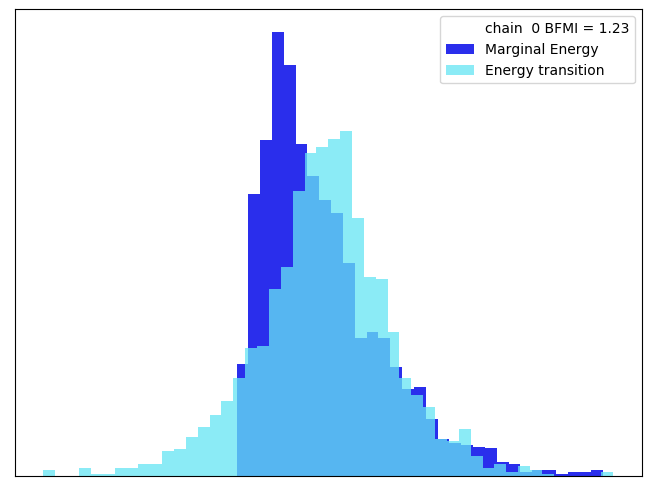

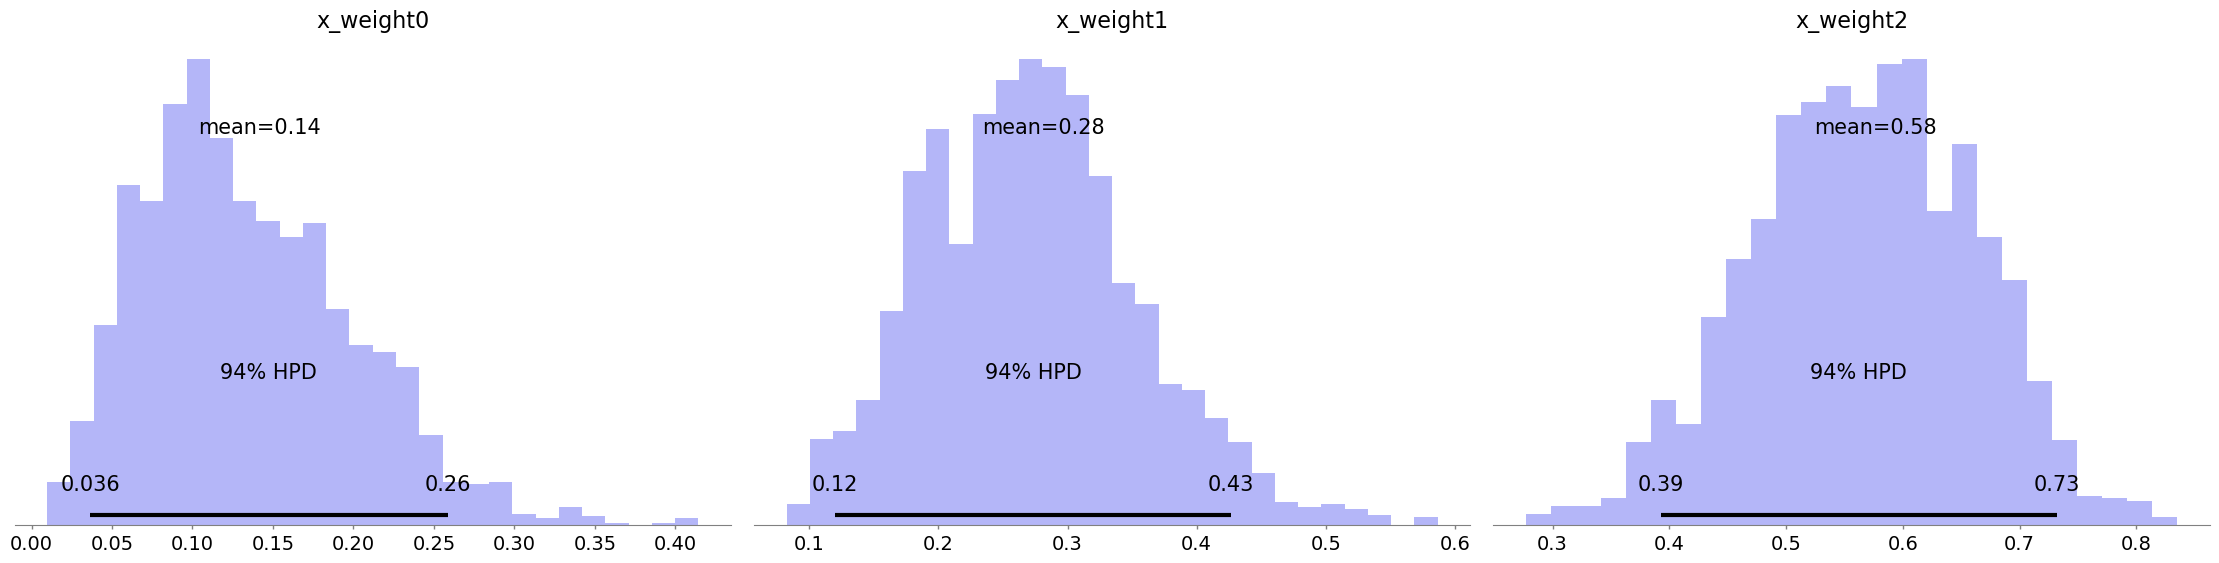

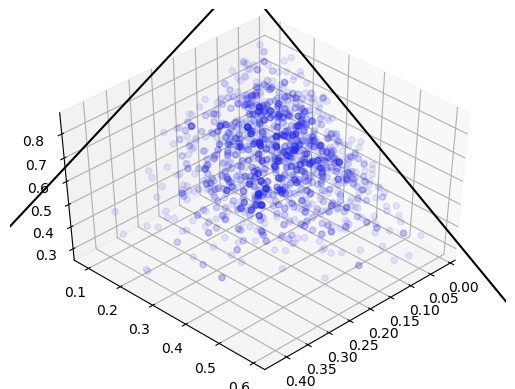

In [30]:
az.plot_energy(hmc_dataset, kind="hist")
az.plot_posterior(hmc_dataset, kind="hist")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    hmc_dataset.posterior.x_weight0,
    hmc_dataset.posterior.x_weight1,
    hmc_dataset.posterior.x_weight2,
    alpha=0.1,
)
ax.add_collection3d(
    Line3DCollection([list(np.eye(3)) + [[1, 0, 0]]], color="k", alpha=1)
)  # Plot simplex
ax.view_init(elev=45, azim=45)
plt.show()

#### RWMC

In [31]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers([mover])
mover.set_radius(0.4)
p.set_weights(get_random_weights(3))

mc.optimize(nsteps)
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(nsteps)
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1174), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1174), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1174), minimum_shape: (chains=2, draws=4)


Acceptance rate: 0.261


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x_weight0,0.144,0.074,0.027,0.275,0.003,0.002,844.0,733.0,895.0,846.0,NaN
x_weight1,0.282,0.097,0.117,0.465,0.003,0.003,776.0,751.0,785.0,718.0,NaN
x_weight2,0.575,0.105,0.382,0.756,0.004,0.003,759.0,759.0,750.0,787.0,NaN


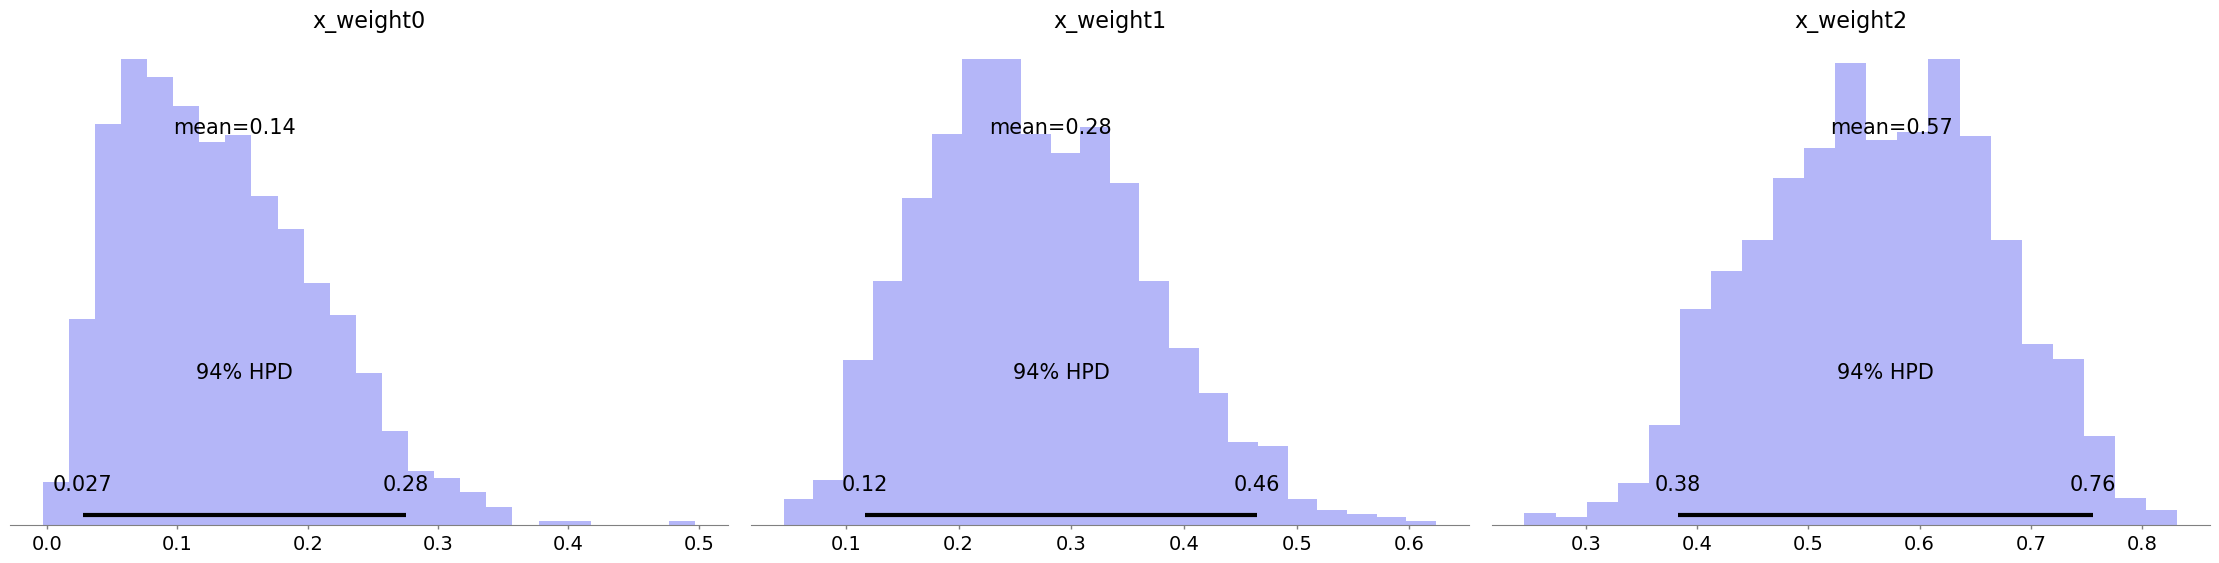

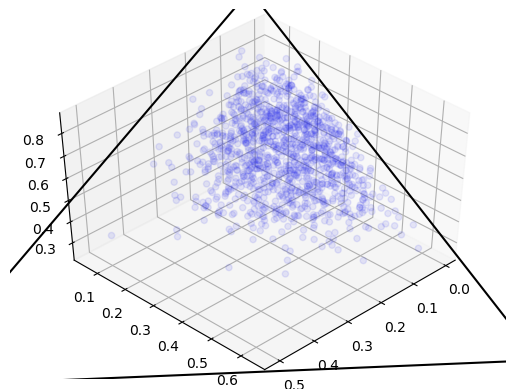

In [32]:
az.plot_posterior(rwmc_dataset, kind="hist")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    rwmc_dataset.posterior.x_weight0,
    rwmc_dataset.posterior.x_weight1,
    rwmc_dataset.posterior.x_weight2,
    alpha=0.1,
)
ax.add_collection3d(
    Line3DCollection([list(np.eye(3)) + [[1, 0, 0]]], color="k", alpha=1)
)  # Plot simplex
ax.view_init(elev=45, azim=45)
plt.show()

In [33]:
ess_ratios = hmc_summary[ess_cols] / rwmc_summary[ess_cols]
ess_ratios.columns = [c + "_ratio" for c in ess_cols]
ess_ratios

,ess_mean_ratio,ess_sd_ratio,ess_bulk_ratio,ess_tail_ratio
x_weight0,0.979858,1.128240,0.918436,0.965721
x_weight1,1.092784,1.129161,1.076433,1.247911
x_weight2,1.151515,1.139657,1.194667,1.078780
